In [1]:
# !rm -rf latent-geometry
# !git clone -b final-project-presentation --single-branch https://github.com/quczer/latent-geometry.git
# # !pip uninstall numpy -y
# !pip install -e latent-geometry[dev]
# # !python latent-geometry/setup.py install

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader

from latent_geometry.model.mnist_vae import EncoderVAE, DecoderVAE
from latent_geometry.mapping import TorchModelMapping
from latent_geometry.visual.plotly import (
    create_topology_fig,
    create_topology_fig_geodesics,
)
from latent_geometry.manifold import LatentManifold
from latent_geometry.metric import EuclideanMetric

import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

from latent_geometry.config import NOTEBOOKS_DIR

In [4]:
transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]
)
testset = torchvision.datasets.MNIST(
    root=NOTEBOOKS_DIR / "input", train=False, download=True, transform=transform
)
testloader = DataLoader(testset, batch_size=10000, shuffle=False)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = torch.load(NOTEBOOKS_DIR / "output" / "encoder", map_location=device)
decoder = torch.load(NOTEBOOKS_DIR / "output" / "decoder", map_location=device)

x = next(iter(testloader))
z, mu, log_var = encoder(x[0].to(device))
reconstruction = decoder(z)

In [6]:
NUM_POINTS = 7000
WIDTH = 4
Z_SCALE = 5.0
SPLINE_POLY_DEG = 3
SIN_MULT = 1.5
SOLVER_TOL = 0.1

In [17]:
# , manifold: LatentManifold, n_points: int = NUM_POINTS, width: float = WIDTH
def create_df(points, labels) -> pd.DataFrame:
    x_1 = points[:, 0]
    x_2 = points[:, 1]

    df = pd.DataFrame(np.stack([x_1, x_2, labels], axis=1), columns=["x", "y", "z"])
    return df


def create_latent_fig(df: pd.DataFrame, three_d: bool = False) -> go.Figure:
    if three_d:
        return px.scatter_3d(df, x="x", y="y", z="z", color="z", opacity=1)
    else:
        return px.scatter(df, x="x", y="y", color="z", opacity=0.25)
        # return px.scatter(df, x="x", y="y", opacity=0.5)  # z tym działało

In [18]:
def create_topology_fig_given_manifold(
    points,
    labels,
    centres: list[np.ndarray],
    manifold: LatentManifold,
    num_lines: int,
    num_circles: int,
    line_length: float = 10,
    show_lines: bool = True,
    show_circles: bool = True,
) -> go.Figure:
    df_ = create_df(points, labels)
    background_trace = create_latent_fig(df_, three_d=False).data[0]

    return create_topology_fig(
        centres,
        manifold,
        background_trace,
        num_lines,
        num_circles,
        line_length,
        show_lines,
        show_circles,
    )

In [19]:
ambient_metric = EuclideanMetric(1024)
latent_mapping = TorchModelMapping(decoder, (2,), (1, 1, 32, 32))
manifold_mnist = LatentManifold(
    latent_mapping,
    ambient_metric,
    solver_tol=SOLVER_TOL,
)

batch = next(iter(testloader))
points, mu, log_var = encoder(batch[0].to(device))

points = points.detach().cpu().numpy()
labels = batch[1]

center = points[0]
centers_1 = points[:10]
centers_2 = points[10:20]

In [23]:
import matplotlib.pyplot as plt


def show_img(latent_point):
    plt.imshow(latent_mapping(latent_point).reshape(32, 32), cmap="gray")

In [21]:
# 6 points = 2min on gpu
# 3 points, 0.1 rtol -> 40s
create_topology_fig_given_manifold(
    points=points,
    labels=labels,
    centres=[np.array([-1, -1]), np.array([0, 0.5]), np.array([1, 0.0])],
    # centres=[],
    manifold=manifold_mnist,
    line_length=10,
    num_lines=9,
    num_circles=4,
).show()

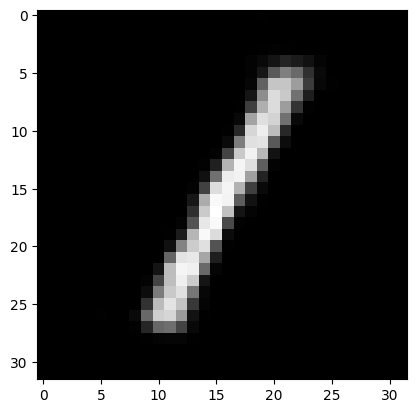

In [38]:
show_img(np.array([-2, -2.5]))